In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.pyplot import plot, draw, show
from scipy.linalg import lu
import scipy.linalg as la
import scipy.stats as st
import random
import simpy
import pandas as pd
import math
from IPython.display import display, HTML

In [44]:
class Queue(object):
    def __init__(self, env, N, resource, helperIndex):
        self.env = env
        self.machine = resource(env, N)
        self.customerHelped = 0
        self.serverN = N
        self.helperIndex = helperIndex

    def helped(self, customer, customerServe, timestmp):
        timestmp.append(self.env.now)
        yield self.env.timeout(customerServe)


def checkTest(now, entertime, customerHelped, runLength, customerLeft, cw,
              tmpWait):
    if customerLeft < runLength:
        return None
    elif customerLeft % runLength == 0:
        if customerLeft != 0:
            if len(cw.subWaitingList) != 0:
                submean = np.mean(cw.subWaitingList)
                del cw.subWaitingList[:]
                return submean
        del cw.subWaitingList[:]
    elif 0 < customerLeft % runLength <= 0.3 * runLength:
        pass
    elif 0.3 * runLength < customerLeft % runLength < runLength:
        tmpWait.append(now - entertime)
        cw.subWaitingList.append(now - entertime)
    return None


def customer(env, cw, resource, serviceScheme, runLength, cid, tmpWait,
             tmpServe, tmpRho, timestmp, tmpSub):
    #     global customerLeft
    if serviceScheme == "Long-Tailed":
        rCheck = random.random()
        if rCheck <= 0.75:
            customerServeTime = np.random.poisson(ltLow[cw.helperIndex])
        else:
            customerServeTime = np.random.poisson(ltHigh[cw.helperIndex])
    elif serviceScheme == "Poisson":
        customerServeTime = np.random.poisson(
            1.0 / serviceTime[cw.helperIndex])
    elif serviceScheme == "Random":
        customerServeTime = random.uniform(
            serviceTime[cw.helperIndex] - randspread[cw.helperIndex],
            serviceTime[cw.helperIndex] + randspread[cw.helperIndex])
    elif serviceScheme == "Deterministic":
        customerServeTime = 1 / serviceTime[cw.helperIndex]
    elif serviceScheme == "Inverse":
        customerServeTime = qServeInv[cw.helperIndex][cw.customerHelped]
    elif serviceScheme == "Exponential":
        customerServeTime = random.expovariate(serviceTime[cw.helperIndex])

    customerServeTime = 0.000001 if customerServeTime == 0 else customerServeTime

    tmpRho.append(
        lambdaIAT[cw.helperIndex] / (cw.serverN * (1 / customerServeTime)))

    enterQueue = env.now
    if resource == simpy.PriorityResource:
        with cw.machine.request(priority=customerServeTime) as request:
            request.time = customerServeTime
            yield request
            cw.customerLeft += 1

            blockMean = checkTest(env.now, enterQueue, cw.customerHelped,
                                  runLength, cw.customerLeft, cw, tmpWait)

            if blockMean != None:
                tmpSub.append(blockMean)

            tmpServe.append(customerServeTime)
            yield env.process(
                cw.helped(cw.customerHelped, customerServeTime, timestmp))

    elif resource == simpy.Resource:
        with cw.machine.request() as request:
            request.time = customerServeTime
            yield request
            cw.customerLeft += 1

            blockMean = checkTest(env.now, enterQueue, cw.customerHelped,
                                  runLength, cw.customerLeft, cw, tmpWait)

            if blockMean != None:
                tmpSub.append(blockMean)

            tmpServe.append(customerServeTime)
            yield env.process(
                cw.helped(cw.customerHelped, customerServeTime, timestmp))


def setup(env, N, lambdaIAT, customerCount, resource, serviceScheme,
          helperIndex, runLength, customerLeft, subWaitingList, tmpWait,
          tmpServe, tmpRho, timestmp, tmpSub):
    queue = Queue(env, N, resource, helperIndex)
    queue.customerLeft = customerLeft
    queue.subWaitingList = subWaitingList
    # Create more customers while the simulation is running
    s = np.random.poisson(1 / lambdaIAT, customerCount)
    #     s = [1 / lambdaIAT for customer in range(customerCount)]
    cid = 0
    for i in range(4):
        cid += 1
        env.process(
            customer(env, queue, resource, serviceScheme, runLength, cid,
                     tmpWait, tmpServe, tmpRho, timestmp, tmpSub))
    while queue.customerHelped < customerCount:
        yield env.timeout(s[queue.customerHelped])
        queue.customerHelped += 1
        cid += 1
        env.process(
            customer(env, queue, resource, serviceScheme, runLength, cid,
                     tmpWait, tmpServe, tmpRho, timestmp, tmpSub))


def runSim(resources, serviceScheme):
    columns = [
        "Rho", "Average", "Variance", "std_dev", "Resource", "Helpers", "run",
        "serviceScheme", "ServeMean", "blockMean"
    ]
    resourceStatsRun = pd.DataFrame(columns=columns)
    customerAll = pd.DataFrame(columns=columns)
    RANDOM_SEED = 0

    for resource in resources:
        for helperIndex, N in enumerate(N_helpers):
            print(str(resource)[33:-2], N)
            runServe = []
            runWait = []
            runRho = []
            times = []
            runSub = []
            for j in range(NRUNS):
                RANDOM_SEED += 1
                random.seed(RANDOM_SEED)
                np.random.seed(RANDOM_SEED)
                timestmp = []
                random.seed(RANDOM_SEED)
                np.random.seed(RANDOM_SEED)
                subWaitingList = []
                customerLeft = 0
                tmpWait = []
                tmpServe = []
                tmpRho = []
                tmpSub = []
                env = simpy.Environment()
                env.process(
                    setup(env, N, lambdaIAT[helperIndex],
                          customerCount[helperIndex], resource, serviceScheme,
                          helperIndex, runLength[helperIndex], customerLeft,
                          subWaitingList, tmpWait, tmpServe, tmpRho, timestmp,
                          tmpSub))
                env.run()

                resourceStatsRun.loc[serviceScheme + "_" + str(resource)[33:-2]
                                     + "_" + str(j) + "_" + str(N)] = [
                                         np.mean(tmpRho),
                                         np.mean(tmpWait),
                                         np.var(tmpWait),
                                         np.std(tmpWait),
                                         str(resource)[33:-2], N, j,
                                         serviceScheme,
                                         np.mean(tmpServe),
                                         np.mean(tmpSub)
                                     ]

                runWait.append(tmpWait)
                runServe.append(tmpServe)
                runRho.append(tmpRho)
                runSub.append(tmpSub)
                times.append(timestmp[-1])

            np.array(runWait).flatten()
            np.array(runServe).flatten()
            np.array(runRho).flatten()
            np.array(runSub).flatten()
            customerAll.loc[serviceScheme + "_" + str(resource)[33:-2] + "_" +
                            str(N)] = [
                                np.mean(runRho),
                                np.mean(runWait),
                                np.var(runWait),
                                np.std(runWait),
                                str(resource)[33:-2], N, None, serviceScheme,
                                np.mean(runServe), np.mean(runSub)
                            ]

    return customerAll, resourceStatsRun

In [25]:
def averageQueueTimesTwee(lamb, mu):
    rho = lamb / mu
    up = (rho**3)
    low = lamb * (1 - (rho**2))
    return up / low


def averageTimesTwee(lamb, mu):
    up = mu**2 + lamb**2
    low = mu * (mu**2 - lamb**2)
    return up / low


def averageCustomersTwee(lamb, mu):
    rho = lamb / mu
    up = rho * (mu**2 + lamb**2)
    low = mu**2 - lamb**2
    return up / low


def averageQueueCustomersTwee(lamb, mu):
    rho = lamb / mu
    up = 2 * rho**3
    low = 1 - rho**2
    return up / low


def C(rho, n):
    up = ((rho**n) / math.factorial(n)) * (n / (n - rho))
    low1 = 0
    for k in range(n):
        low1 += ((rho**k) / math.factorial(k))
    low2 = ((rho**n) * n) / (math.factorial(n) * (n - rho))
    low = low1 + low2
    return up / low


def ErlangC(A, N):
    L = (A**N / math.factorial(N)) * (N / (N - A))
    sum_ = 0
    for i in range(N):
        sum_ += (A**i) / math.factorial(i)
    return (L / (sum_ + L))


def Wq(rho, mu, n):
    Pq = C(rho, n)
    a = 1 / (mu * (n - rho))
    return a * Pq


def averageQueueTimesOne(lamb, mu):
    rho = lamb / mu
    up = rho
    low = mu * (1 - rho)
    return up / low


def getConf(rRD, var, n, l, u, rho):
    data = {}

    for resource in resources:
        data.setdefault(resource, {})
        for N in N_helpers:
            data[resource].setdefault(N, [])
            a = list(rRD.loc[(rRD.Resource == str(resource)[33:-2])
                             & (rRD.Helpers == N)][var])
            interval = st.t.interval(
                0.95, len(a) - 1, loc=np.mean(a), scale=st.sem(a))
            data[resource][N].append(interval)

            data[resource]["SampleSize" + str(N)] = np.sqrt(
                np.std(a) / (np.mean(a) - Wq(N * rho, u, n)))

    return data

In [46]:
# Init simulation specific parameters
N_helpers = [1]  # Number of machines in the queue
chanceLongTail = 0.75  # Chance of longtail lowerbound
NRUNS = 350
lI = 8.0 / 5
lambdaIAT = [N * lI for N in N_helpers]  # Create a customer every ~lI minutes
cC = 5000
customerCount = [N * cC for N in N_helpers]  # Amount of customers
rL = 1000
runLength = [N * rL for N in N_helpers]  # Amount of customer per average block

# Init servicetimes
# Minutes it takes to help a customer / Deterministic
serveT = 2
serviceTime = [serveT for N in N_helpers]
# Lower bound long-tailed distribution
ltLow = [10 for N in N_helpers]
# Upper bound long-tailed distribution
ltHigh = [50 for N in N_helpers]
# Spread of the random distribution
randspread = [1 for N in N_helpers]
# max service time for the inverse servicetime
invMax = [45 for N in N_helpers]
# Inverse servetimes
qServeInv = [[
    i for i in range(invMax[queueIndex], -1, -1)
    for x in range(math.ceil(customerCount[queueIndex] / invMax[queueIndex]))
] for queueIndex in range(len(N_helpers))]

rho = lI / serveT
resources = [simpy.PriorityResource]

In [47]:
serviceScheme = "Deterministic"
customerAllDet, resourceRunDet = runSim(resources, serviceScheme)

PriorityResource 1


,,,count,mean,std,min,25%,50%,75%,max
serviceScheme,Resource,Helpers,,,,,,,,
Deterministic,PriorityResource,1,350.0,1.889365,0.30268,1.270386,1.680347,1.847818,2.062187,3.009299


{<class 'simpy.resources.resource.PriorityResource'>: {1: [(1.8575449564778905, 1.9211858834975848)], 'SampleSize1': nan}}


C:\Users\chatel\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:89: RuntimeWarning: invalid value encountered in sqrt


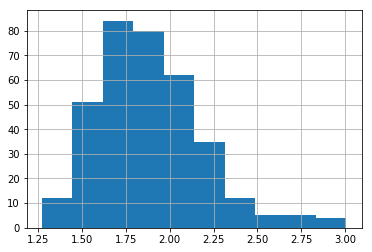

In [57]:
grp = resourceRunDet.groupby(["serviceScheme", "Resource", "Helpers"])
grpDescr = grp.describe()
display(HTML(grpDescr.blockMean.to_html()))
print(getConf(resourceRunDet, "blockMean", 1, lI, serveT, rho))
resourceRunDet.loc[(resourceRunDet.Resource == "PriorityResource")
                   & (resourceRunDet.Helpers == 1)]["blockMean"].hist()

In [55]:
serviceScheme = "Poisson"
customerAllPoi, resourceRunPoi = runSim(resources, serviceScheme)

PriorityResource 1


,,,count,mean,std,min,25%,50%,75%,max
serviceScheme,Resource,Helpers,,,,,,,,
Poisson,PriorityResource,1,350.0,1.13797,0.211155,0.723543,1.007349,1.095335,1.262547,2.322347


{<class 'simpy.resources.resource.PriorityResource'>: {1: [(1.115771345162714, 1.1601684284950498)], 'SampleSize1': nan}}


C:\Users\chatel\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:89: RuntimeWarning: invalid value encountered in sqrt


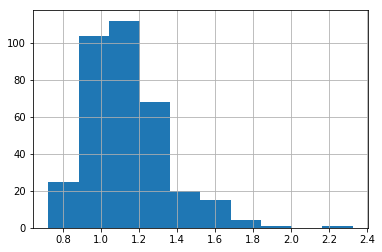

In [58]:
grp = resourceRunPoi.groupby(["serviceScheme", "Resource", "Helpers"])
grpDescr = grp.describe()
display(HTML(grpDescr.blockMean.to_html()))
print(getConf(resourceRunPoi, "blockMean", 1, lI, serveT, rho))
resourceRunPoi.loc[(resourceRunPoi.Resource == "PriorityResource")
                   & (resourceRunPoi.Helpers == 1)]["blockMean"].hist()

In [33]:
serviceScheme = "Exponential"
customerAllExp, resourceRunExp = runSim(resources, serviceScheme)

PriorityResource 1
PriorityResource 2
PriorityResource 4
Resource 1
Resource 2
Resource 4


In [34]:
grp = resourceRunExp.groupby(["serviceScheme", "Resource", "Helpers"])
grpDescr = grp.describe()
display(HTML(grpDescr.blockMean.to_html()))
print(getConf(resourceRunExp, "blockMean", 1, lI, serveT, rho))

{<class 'simpy.resources.resource.PriorityResource'>: {1: [(1.2249265253681303, 1.3495391163488204)], 'SampleSize1': nan, 2: [(0.980962062555201, 1.0749906690843292)], 'SampleSize2': 0.22896388577542615, 4: [(0.8894209579558344, 0.9556308396567651)], 'SampleSize4': 0.229857881441723}, <class 'simpy.resources.resource.Resource'>: {1: [(2.671466412695453, 3.037529329399343)], 'SampleSize1': 0.7509929114703743, 2: [(2.1900781031652965, 2.4986161304324037)], 'SampleSize2': 0.3323386229599712, 4: [(1.8838089396768232, 2.2221627245410036)], 'SampleSize4': 0.40027308519172683}}


C:\Users\chatel\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:89: RuntimeWarning: invalid value encountered in sqrt


In [37]:
serviceScheme = "Long-Tailed"
customerAllLT, resourceRunLT = runSim(resources, serviceScheme)

In [ ]:
grp = resourceRunLT.groupby(["serviceScheme", "Resource", "Helpers"])
grpDescr = grp.describe()
display(HTML(grpDescr.blockMean.to_html()))
print(getConf(resourceRunLT, "blockMean", 1, lI, serveT, rho))